In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib import font_manager
from tqdm import tqdm

# ============================
# 1. Data Processing Functions
# ============================
def read_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None, names=["target", "input", "score"])
    df = df.dropna(subset=["input", "target"])
    df = df.astype({"input": str, "target": str})
    return df["input"].tolist(), df["target"].tolist()

def build_vocab(sequences):
    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
    idx = 3
    chars = set(ch for seq in sequences for ch in seq)
    for ch in sorted(chars):
        vocab[ch] = idx
        idx += 1
    return vocab

def encode_sequence(seq, vocab, max_len=None):
    ids = [vocab["<sos>"]] + [vocab[c] for c in seq] + [vocab["<eos>"]]
    if max_len:
        ids = ids[:max_len-1] + [vocab["<eos>"]]
        ids += [vocab["<pad>"]] * (max_len - len(ids))
    return ids

def prepare_transliteration_dataset(file_path, max_len=30):
    inputs, targets = read_data(file_path)
    input_vocab = build_vocab(inputs)
    input_vocab = dict(sorted(input_vocab.items(), key=lambda item: item[0]))
    target_vocab = build_vocab(targets)
    target_vocab = dict(sorted(target_vocab.items(), key=lambda item: item[0]))
    inv_input_vocab = {v: k for k, v in input_vocab.items()}
    inv_target_vocab = {v: k for k, v in target_vocab.items()}
    input_tensor = [encode_sequence(seq, input_vocab, max_len) for seq in inputs]
    target_tensor = [encode_sequence(seq, target_vocab, max_len) for seq in targets]
    return input_tensor, target_tensor, input_vocab, target_vocab, inv_input_vocab, inv_target_vocab

# ============================
# 2. Dataset
# ============================
class TransliterationDataset(Dataset):
    def __init__(self, input_tensor, target_tensor):
        self.inputs = input_tensor
        self.targets = target_tensor

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

# ============================
# 3. Encoder
# ============================
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=2, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

# ============================
# 4. Attention
# ============================
class Attention(nn.Module):
    def __init__(self, hidden_dim, attn_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size, src_len, _ = encoder_outputs.size()
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

# ============================
# 5. Decoder (returns attn weights)
# ============================
class DecoderLSTM(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, attention):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        self.lstm = nn.LSTM(emb_dim + enc_hidden_dim, dec_hidden_dim, num_layers=2, batch_first=True)
        self.fc_out = nn.Linear(enc_hidden_dim * 2 + emb_dim, output_dim)
        self.output_dim = output_dim

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        attn_weights = self.attention(hidden[-1], encoder_outputs).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        output = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim=1))
        return output, hidden, cell, attn_weights.squeeze(1)  # Return attn weights

# ============================
# 6. Seq2Seq Model (optionally returns attn weights)
# ============================
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5, return_attentions=False):
        batch_size, trg_len = trg.shape
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        all_attentions = []

        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell, attn_weights = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            if return_attentions:
                all_attentions.append(attn_weights.detach().cpu())
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        if return_attentions:
            all_attentions = torch.stack(all_attentions, dim=0).transpose(0, 1)
            return outputs, all_attentions
        return outputs

# ============================
# 7. Decoding
# ============================
def decode_output(sequence, inv_vocab):
    tokens = []
    for idx in sequence:
        idx = idx.item() if isinstance(idx, torch.Tensor) else idx
        token = inv_vocab.get(idx, "")
        if token in ["<sos>", "<eos>", "<pad>"]:
            continue
        tokens.append(token)
    return "".join(tokens)

# ============================
# 8. Training & Evaluation
# ============================
def train(model, dataloader, optimizer, criterion, inv_target_vocab, clip=1):
    model.train()
    epoch_loss, correct_words, total_words = 0, 0, 0

    for src, trg in tqdm(dataloader, desc="Training"):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]

        loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

        predictions = output.argmax(2)
        for pred_seq, true_seq in zip(predictions, trg):
            pred_word = decode_output(pred_seq, inv_target_vocab)
            true_word = decode_output(true_seq, inv_target_vocab)
            if pred_word == true_word:
                correct_words += 1
            total_words += 1

    acc = correct_words / total_words
    return model, epoch_loss / len(dataloader), acc

def evaluate_frompath(model, dataloader, criterion, inv_target_vocab, val_tsv_path):
    model.eval()
    epoch_loss, correct_words, total_words = 0, 0, 0

    with open(val_tsv_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        true_words_list = [line.strip().split("\t")[0] for line in lines]

    true_word_idx = 0
    with torch.no_grad():
        for src, trg in tqdm(dataloader, desc="Evaluating"):
            src, trg = src.to(device), trg.to(device)
            batch_size = src.shape[0]
            batch_true_words = true_words_list[true_word_idx:true_word_idx + batch_size]
            true_word_idx += batch_size

            output = model(src, trg, teacher_forcing_ratio=0.0)
            output_dim = output.shape[-1]
            loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
            epoch_loss += loss.item()

            predictions = torch.argmax(output, dim=-1)
            for pred_seq, true_word in zip(predictions, batch_true_words):
                pred_word = decode_output(pred_seq, inv_target_vocab)
                if pred_word == true_word:
                    correct_words += 1
                total_words += 1

    acc = correct_words / total_words
    return epoch_loss / len(dataloader), acc


# ============================
# 9. Main: Training
# ============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training data
train_inputs, train_targets, input_vocab, target_vocab, inv_input_vocab, inv_target_vocab = \
    prepare_transliteration_dataset("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv", max_len=30)
train_dataset = TransliterationDataset(train_inputs, train_targets)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Validation data
val_tsv_path = "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
val_inputs, val_targets, _, _, _, _ = \
    prepare_transliteration_dataset(val_tsv_path, max_len=30)
val_dataset = TransliterationDataset(val_inputs, val_targets)
val_loader = DataLoader(val_dataset, batch_size=128)

# Model configuration
INPUT_DIM = len(input_vocab)
OUTPUT_DIM = len(target_vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 128

attn = Attention(HID_DIM, HID_DIM)
enc = EncoderLSTM(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = DecoderLSTM(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, attn)
model = Seq2Seq(enc, dec, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
PAD_IDX = target_vocab["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Train loop
for epoch in range(1, 2):
    model, train_loss, train_acc = train(model, train_loader, optimizer, criterion, inv_target_vocab)
    val_loss, val_acc = evaluate_frompath(model, val_loader, criterion, inv_target_vocab, val_tsv_path)
    print(f"Epoch {epoch}")
    print(f"Train     | Loss: {train_loss:.4f} | Word Acc: {train_acc*100:.2f}%")
    print(f"Val       | Loss: {val_loss:.4f}   | Word Acc: {val_acc*100:.2f}%\n")

Evaluating: 100%|██████████| 35/35 [00:02<00:00, 14.74it/s]

Epoch 1
Train     | Loss: 2.1141 | Word Acc: 1.71%
Val       | Loss: 4.3722   | Word Acc: 7.92%



In [2]:
import csv

def decode_output(sequence, inv_vocab):
    tokens = []
    for idx in sequence:
        idx = idx.item() if isinstance(idx, torch.Tensor) else idx
        token = inv_vocab.get(idx, "")
        if token in ["<sos>", "<eos>", "<pad>"]:
            continue
        tokens.append(token)
    return "".join(tokens)

def test_and_save_predictions(model, dataloader, criterion, inv_source_vocab, inv_target_vocab, test_tsv_path, output_csv_path):
    model.eval()
    correct_words, total_words = 0, 0

    # Load source and target words from test.tsv
    with open(test_tsv_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        test_data_pairs = [line.strip().split("\t") for line in lines]  # [source_word, target_word]

    results = []
    data_index = 0

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            batch_size = src.shape[0]

            output = model(src, trg, teacher_forcing_ratio=0.0)
            predictions = torch.argmax(output, dim=-1)

            for i in range(batch_size):
                pred_word = decode_output(predictions[i], inv_target_vocab)
                src_word = test_data_pairs[data_index][1]
                tgt_word = test_data_pairs[data_index][0]

                results.append([src_word, tgt_word, pred_word])

                if pred_word == tgt_word:
                    correct_words += 1
                total_words += 1
                data_index += 1

    accuracy = (correct_words / total_words) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Save results to CSV
    with open(output_csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Source Word", "Target Word", "Predicted Word"])
        writer.writerows(results)

    print(f"Saved predictions to {output_csv_path}")
    return accuracy

test_path = "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"
test_inputs, test_targets, _, _, _, _ = \
    prepare_transliteration_dataset(test_path, max_len=30)
test_dataset = TransliterationDataset(test_inputs, test_targets)
test_loader = DataLoader(test_dataset, batch_size=128)
accuracy = test_and_save_predictions(
    model=model,
    dataloader=test_loader,
    criterion=criterion,
    inv_source_vocab=inv_input_vocab,
    inv_target_vocab=inv_target_vocab,
    test_tsv_path= test_path,
    output_csv_path="/kaggle/working/predictions_with_att.csv"
)


Test Accuracy: 9.06%
Saved predictions to /kaggle/working/predictions_with_att.csv


In [3]:
import pandas as pd
pd.read_csv("/kaggle/working/predictions_with_att.csv") 

,Source Word,Target Word,Predicted Word
0,ank,अंक,आकक
1,anka,अंक,अका
2,ankit,अंकित,अक्टी
3,anakon,अंकों,अनकों
4,ankhon,अंकों,अंखों
...,...,...,...
4497,holding,होल्डिंग,होलिंग
4498,hoshangabaad,होशंगाबाद,होशनगाबा
4499,hoshangabad,होशंगाबाद,होहांगाद
4500,hostes,होस्टेस,होस्स


# Heatmap

In [4]:
from matplotlib import font_manager
import matplotlib

# Register and set the font globally for all matplotlib text
devanagari_font_path = "/kaggle/input/dev-data1/NotoSansDevanagari-VariableFont_wdth,wght.ttf"
font_prop = font_manager.FontProperties(fname=devanagari_font_path, size=16)
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans Devanagari']
matplotlib.rcParams['axes.unicode_minus'] = False


In [7]:
from matplotlib import font_manager, rcParams

devanagari_font_path = "/kaggle/input/dev-data/NotoSansDevanagari-VariableFont_wdth,wght.ttf"

# Register font
font_manager.fontManager.addfont(devanagari_font_path)
# Extract family name from font file
prop = font_manager.FontProperties(fname=devanagari_font_path)
family_name = prop.get_name()

# Set as default for all sans-serif
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [family_name]
rcParams['axes.unicode_minus'] = False


import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(ax, attn_matrix, input_seq, output_seq, inv_input_vocab, inv_target_vocab, font_prop):
    input_tokens = [inv_input_vocab[idx] for idx in input_seq if inv_input_vocab[idx] not in ["<pad>", "<sos>", "<eos>"]]
    output_tokens = [inv_target_vocab[idx] for idx in output_seq if inv_target_vocab[idx] not in ["<pad>", "<sos>", "<eos>"]]
    sns.heatmap(
        attn_matrix[:len(output_tokens), :len(input_tokens)],
        xticklabels=input_tokens,
        yticklabels=output_tokens,
        cmap='viridis',
        cbar=False,
        ax=ax
    )
    ax.set_xlabel("Input", fontproperties=font_prop)
    ax.set_ylabel("Output", fontproperties=font_prop)
    ax.tick_params(axis='x', labelrotation=90)
    # Force font for all tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_prop)
        label.set_fontsize(12)


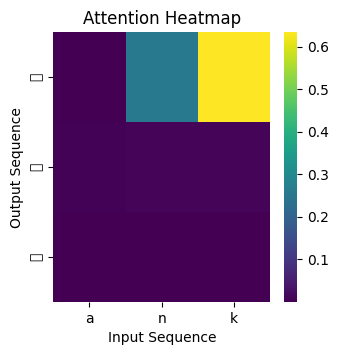

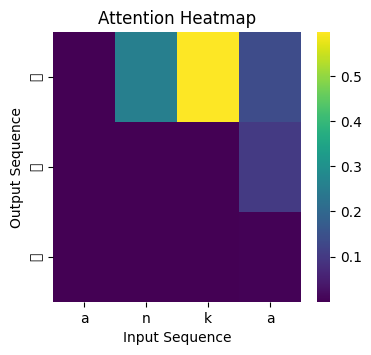

In [11]:
test_path = '/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'
test_inputs, test_targets, _, _, inv_input_vocab, inv_target_vocab = prepare_transliteration_dataset(test_path, max_len=30)
test_dataset = TransliterationDataset(test_inputs, test_targets)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def plot_attention_heatmap(attn_matrix, input_seq, output_seq, inv_input_vocab, inv_target_vocab):
    # Remove special tokens for display
    input_tokens = [inv_input_vocab[idx] for idx in input_seq if inv_input_vocab[idx] not in ["<pad>", "<sos>", "<eos>"]]
    output_tokens = [inv_target_vocab[idx] for idx in output_seq if inv_target_vocab[idx] not in ["<pad>", "<sos>", "<eos>"]]

    plt.figure(figsize=(len(input_tokens) * 0.5 + 2, len(output_tokens) * 0.5 + 2))
    sns.heatmap(attn_matrix[:len(output_tokens), :len(input_tokens)], 
                xticklabels=input_tokens, yticklabels=output_tokens, 
                cmap='viridis', cbar=True)
    plt.xlabel("Input Sequence")
    plt.ylabel("Output Sequence")
    plt.title("Attention Heatmap")
    plt.show()

model.eval()
num_samples = 2  # Number of test samples to visualize

with torch.no_grad():
    for idx, (src, trg) in enumerate(test_loader):
        if idx >= num_samples:
            break
        src, trg = src.to(device), trg.to(device)
        # Forward pass with attention collection
        output, attn_weights = model(src, trg, teacher_forcing_ratio=0.0, return_attentions=True)
        pred_seq = output.argmax(2)[0].cpu().numpy()
        attn_matrix = attn_weights[0].cpu().numpy()  # (output_len-1, input_len)
        input_seq = src[0].cpu().numpy()
        output_seq = pred_seq

        plot_attention_heatmap(attn_matrix, input_seq, output_seq, inv_input_vocab, inv_target_vocab)


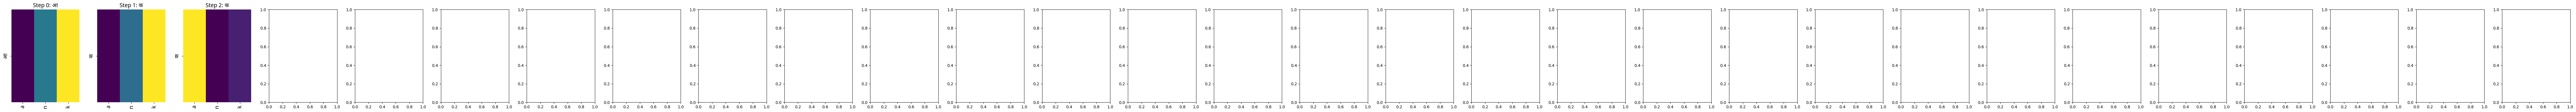

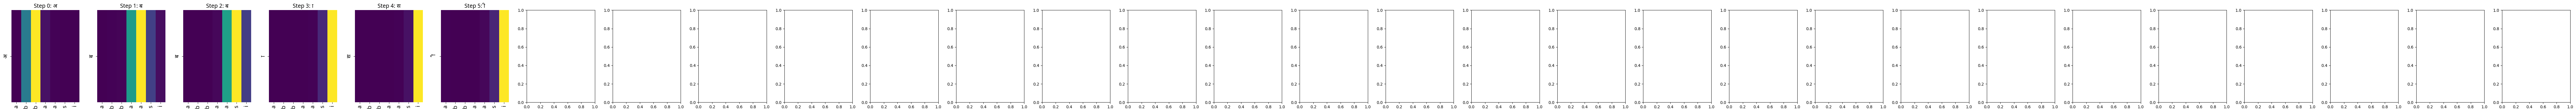

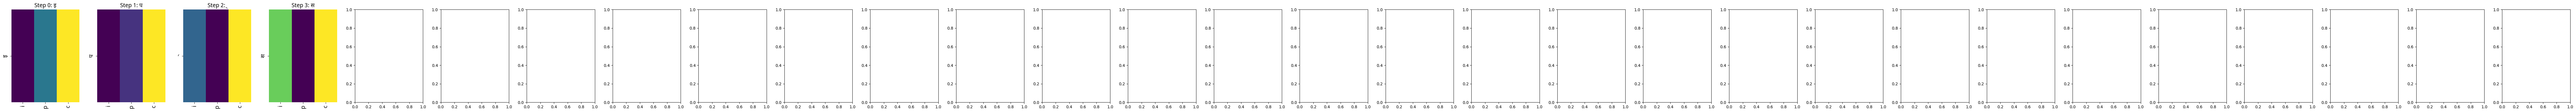

In [9]:
import warnings
warnings.filterwarnings('ignore')

def visualize_attention(input_word, output_word, attn_weights, inv_input_vocab, inv_target_vocab, font_prop):
    """
    Plots attention weights as heatmaps with Devanagari labels
    """
    fig, axes = plt.subplots(1, len(output_word), figsize=(len(output_word)*3, 4))
    if len(output_word) == 1:
        axes = [axes]
    
    # Remove special tokens from input/output
    input_chars = [inv_input_vocab[idx] for idx in input_word if inv_input_vocab[idx] not in ["<pad>", "<sos>", "<eos>"]]
    output_chars = [inv_target_vocab[idx] for idx in output_word if inv_target_vocab[idx] not in ["<pad>", "<sos>", "<eos>"]]
    
    for idx, (char, ax) in enumerate(zip(output_chars, axes)):
        attn = attn_weights[idx][:len(input_chars)].cpu().numpy()
        sns.heatmap(
            np.array([attn]), 
            annot=False, 
            cbar=False, 
            xticklabels=input_chars,
            yticklabels=[char],
            ax=ax,
            cmap='viridis'
        )
        ax.set_title(f'Step {idx}: {char}', fontproperties=font_prop)
        ax.tick_params(axis='x', labelrotation=90, labelsize=12)
        ax.tick_params(axis='y', labelsize=14)
        
        # Set Devanagari font for all labels
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(font_prop)
    
    plt.tight_layout()
    plt.show()

# Example usage with your model and data
def analyze_samples(model, test_loader, inv_input_vocab, inv_target_vocab, font_prop, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i, (src, trg) in enumerate(test_loader):
            if i >= num_samples:
                break
            src, trg = src.to(device), trg.to(device)
            output, attn_weights = model(src, trg, teacher_forcing_ratio=0.0, return_attentions=True)
            
            # Decode sequences
            input_seq = src[0].cpu().numpy()
            output_seq = output.argmax(2)[0].cpu().numpy()
            
            visualize_attention(
                input_seq, 
                output_seq, 
                attn_weights[0], 
                inv_input_vocab, 
                inv_target_vocab,
                font_prop
            )

# Run analysis with font configuration
devanagari_font_path = "/kaggle/input/dev-data1/NotoSansDevanagari-VariableFont_wdth,wght.ttf"
font_prop = font_manager.FontProperties(fname=devanagari_font_path, size=14)

analyze_samples(model, test_loader, inv_input_vocab, inv_target_vocab, font_prop)
